# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer

from sbi.simulators import linear_gaussian

from sbi.inference import SNPE, SNLE, SNRE, infer, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.posteriors.base_posterior import NeuralPosterior

import sbi.utils as utils
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import ActiveSubspace, pairplot

In [3]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [4]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [5]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on sbi: v0.18.0


In [9]:
cwd = os.getcwd()
cwd

'/data/SBI/VEP_SBI-master'

In [10]:
Res_dir='Res_BVEP_sde_sbi_maf_seeg_GrExp_patient1_v18_1step'

### Constants

In [11]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [12]:
cwd = os.getcwd()
cwd

'/data/SBI/VEP_SBI-master'

## Structural Connectivity and Gain Matrices

In [13]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData_CJ", "weights.txt"))

In [14]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [15]:
weights.min(), weights.max()

(0.0, 1.0)

In [16]:
Gr = np.loadtxt(os.path.join(cwd+"/ExperimentalData_CJ", "gain_inv-square.txt"))

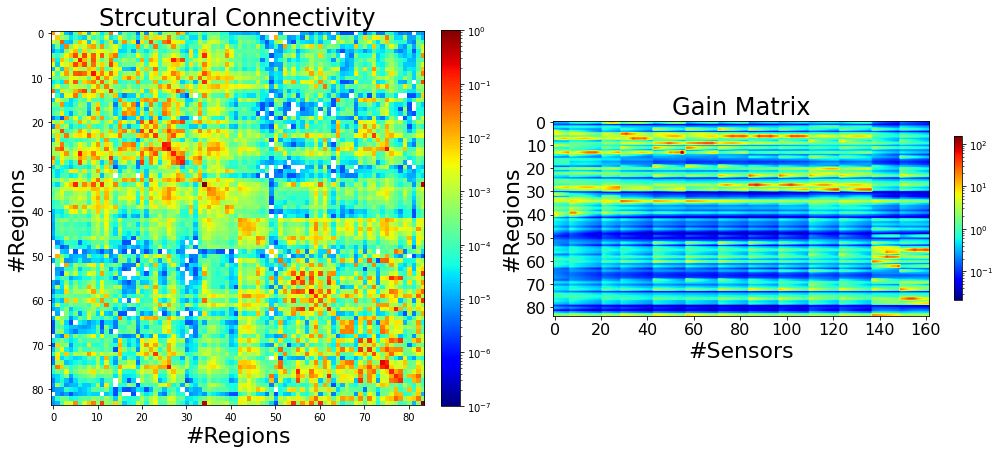

In [17]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.subplot(122)
norm = colors.LogNorm(Gr.min(), Gr.max())
im = plt.imshow(Gr.transpose(),norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.02, pad=0.06)
plt.gca().set_title('Gain Matrix', fontsize=24.0)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Sensors', fontsize=22.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_GainMatrix.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_GainMatrix.svg"), dpi=800)
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [18]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [19]:
#Here, confidential medical information
weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

weights[np.diag_indices(weights.shape[0])] = 0

In [20]:
SC=weights
SC.shape

(84, 84)

### Selected nodes and contacts

In [21]:
contacts = []
with open(cwd+ '/ExperimentalData_CJ/complex_raw.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

In [22]:
reg_xyz = np.loadtxt(cwd+ '/ExperimentalData_CJ/centers.txt', usecols=(1,2,3))

reg_names = []
with open(cwd+ '/ExperimentalData_CJ/centers.txt', 'r') as fd:
    #for line in fd.readlines():
     #   reg_names.append(line.strip().split()[0])
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))
#seg = nibabel.load('aparcaseg_2_diff_2.nii.gz')
#reg_xyz = seg.affine.dot(c_[reg_xyz, ones((reg_xyz.shape[0], ))].T)[:3].T

In [23]:
seeg_xyz = np.loadtxt(cwd+ '/ExperimentalData_CJ/elecs_name.txt', usecols=(1,2,3))

seeg_labels = []

with open(cwd+ '/ExperimentalData_CJ/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
#print sorted(seeg_labels+[e+str(i) for e, i in contacts])
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = np.array([seeg_xyz[i] for i in monopolar_chan_to_pos])

In [24]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [25]:
selectednodes=np.array([ 5,  6,  11,  27, 34])
r_selectednodes=reg_xyz[selectednodes]

Ps=np.array([] ) 

selectedcontacts=[bipnames[c] for c in Ps]

ss=[]
sss=[]
for s in selectedcontacts:
    parts = s.strip().split('-')
    name, idx=re.match("([A-Za-z]+[']*)([0-9]+)", s).groups()
    idx = int(idx)
    #sss.append((name, idx))
    ss.append(parts[0].upper())
    
    
selectedcontacts_indices=[contacts_labels.index(c) for c in ss] 
r_selectedcontacts=seeg_xyz[selectedcontacts_indices]


In [26]:
def plot_selected_nodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(ra, rb, color='k', s=50)
        plt.scatter(sa, sb ,color='b',marker='^', s=5 )
    x, y, z = zip(r_selectednodes.T, r_selectedcontacts.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(ra, rb,color='r', s=50)
        plt.scatter(sa, sb, color='r',marker='^', s=20)
        plt.axis([-120, 100, -120, 100])
        #xticks([]), yticks([])

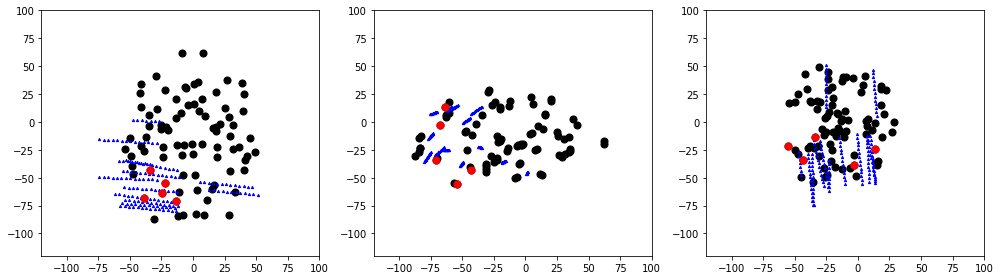

In [27]:
plt.figure(figsize=(14, 4))
plot_selected_nodes()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SelectedNodesandElectrodes.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SelectedNodesandElectrodes.svg"), dpi=800)
plt.show()

In [28]:
nn=reg_xyz.shape[0]
ns=seeg_xyz.shape[0]

nn, ns

(84, 162)

In [29]:
dst=np.zeros((nn, ns))

In [30]:
from scipy.spatial import distance
for i in range(0, nn):
    for j in range(0, ns):
        dst[i,j] = distance.euclidean(reg_xyz[i,: ], seeg_xyz[j,: ])

In [31]:
dist_best=np.min(dst, axis=1)

In [32]:
dist_best.shape

(84,)

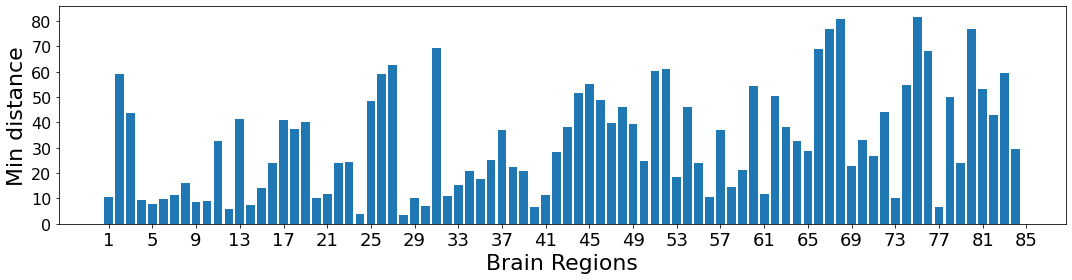

In [33]:
plt.figure(figsize=(15, 4))
plt.bar(np.r_[0:nn], dist_best)
plt.ylabel('Min distance',fontsize=22)
plt.xlabel('Brain Regions',fontsize=22)
plt.xticks(np.arange(0,nn+1, step=4), np.arange(1,nn+2, step=4),fontsize=18, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"NodesDistances.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"NodesDistances.svg"), dpi=800)
plt.show()

In [34]:
elecnames=[]
electrodes = {}  
with open(cwd+ '/ExperimentalData_CJ/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]

In [35]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

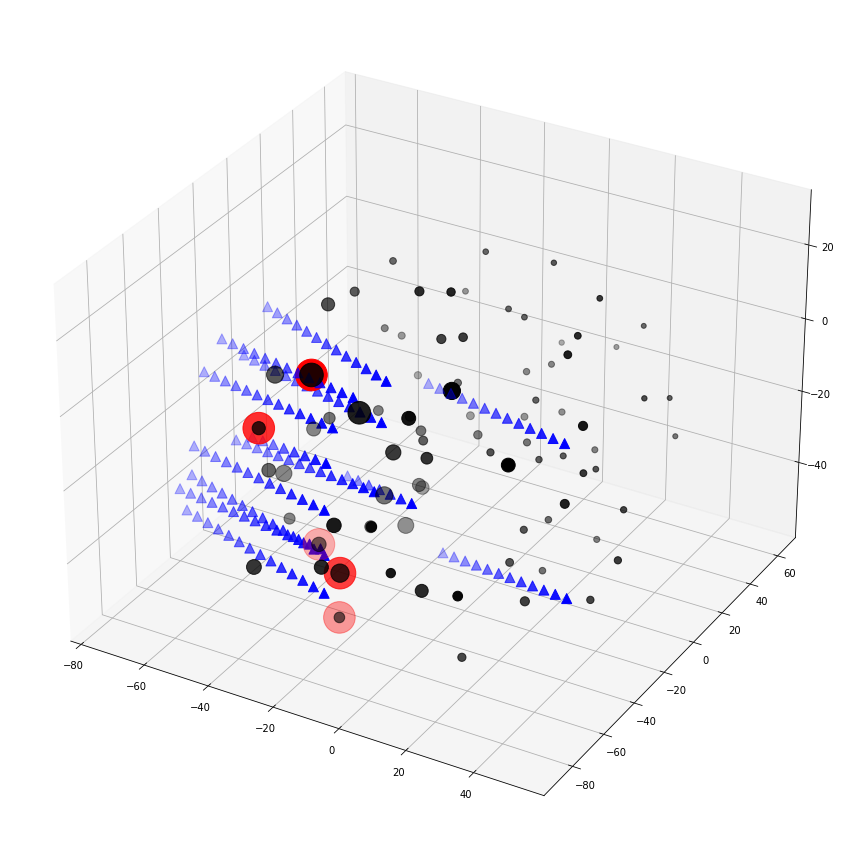

In [36]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color='k', s=2000./dist_best,  label='regions')
ax.scatter(r_selectednodes [:, 0], r_selectednodes [:, 1], r_selectednodes [:, 2], color='r', s=1000, label='selectedregions')
ax.scatter(r_selectedcontacts [:, 0], r_selectedcontacts [:, 1], r_selectedcontacts [:, 2], color='cyan',marker='^', s=300, label='selectecontacts')


for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2],marker='^', color='b', s=100, label=name)
    

#plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SelectedNodesandElectrodes3D.png"), dpi=800)
#ax.view_init(-390, 30)

plt.show()    

### Simulator

In [37]:
from BVEP_Simulator import VEP2Dmodel

### some simulations for  sanity check

In [38]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [39]:
nt=ts.shape[0]
nt

141

In [40]:
nn=SC.shape[0]
nn

84

In [41]:
Gr.shape

(162, 84)

In [42]:
ns=Gr.shape[0]
ns

162

In [43]:
tau=10.
sigma=10e-1
constants = np.array([tau, sigma])
constants

array([10.,  1.])

In [44]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [45]:
K_true=1.

In [46]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [47]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [48]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 5.516669988632202


In [49]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.003233671188354492


In [50]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

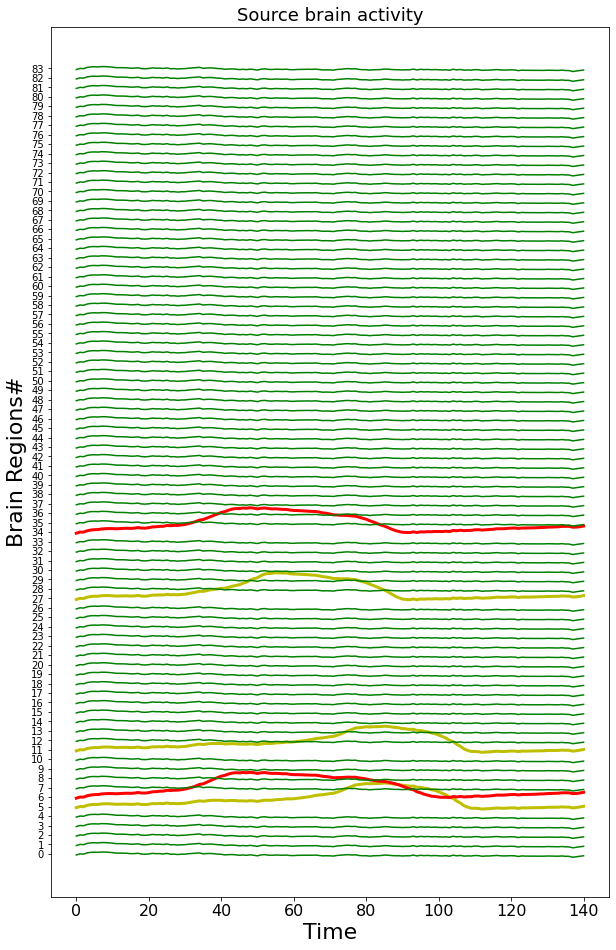

In [51]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

### Seeg signal

In [52]:
X.shape, Gr.shape

((84, 141), (162, 84))

In [53]:
Seeg= np.dot(Gr, np.exp(X))
Seeg.shape

(162, 141)

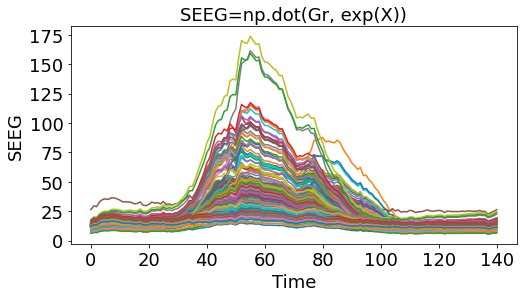

In [54]:
plt.figure(figsize=(8,4))
plt.plot(Seeg.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, exp(X))",fontsize=18)
plt.show()

### Seeg features

In [55]:
Seeg.shape, Gr.shape

((162, 141), (162, 84))

In [56]:
Seeg_area = np.trapz(Seeg, dx=0.0001)
Seeg_area.shape

(162,)

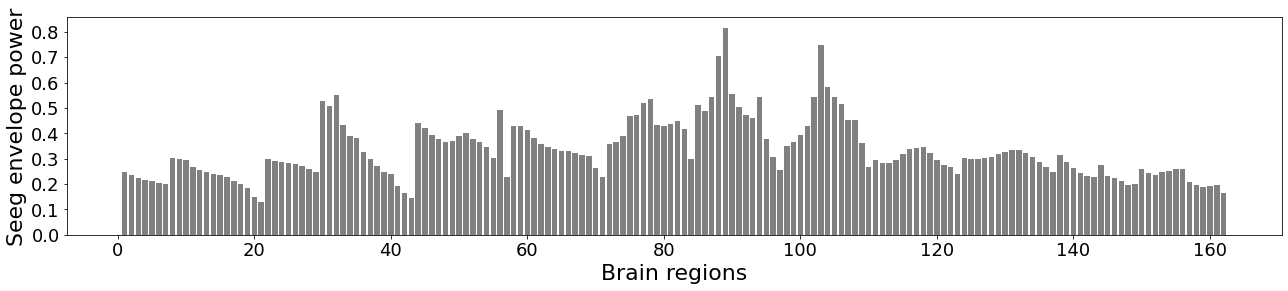

In [57]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='grey');
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Seeg envelope power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SEEG_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SEEG_envelop_power.svg"), dpi=800)
plt.show()

In [58]:
Seeg_pwr = np.sum((Seeg*Seeg), axis=1)
Seeg_pwr_n = (Seeg_pwr/ Seeg_pwr.max())

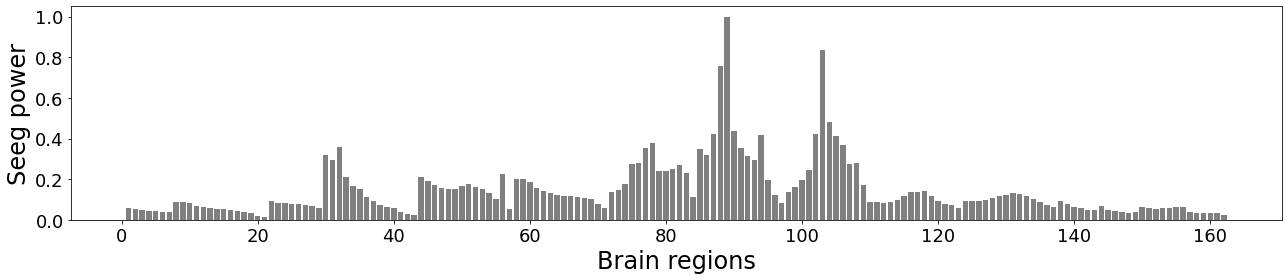

In [59]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_pwr.shape[0]+1), Seeg_pwr_n, color='grey');
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('Seeg power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SEEG_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SEEG_envelop_power_normalize.svg"), dpi=800)
plt.show()

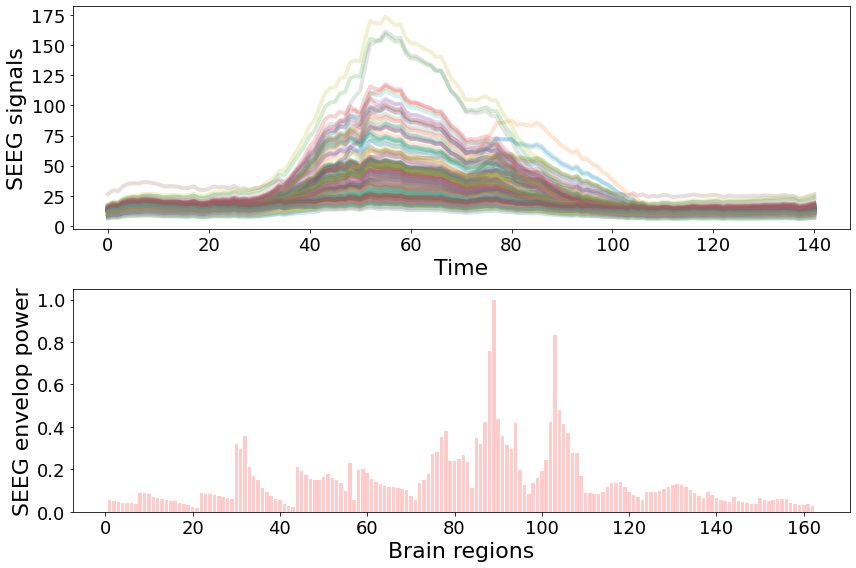

In [60]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(Seeg.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='r', alpha=0.2)
#plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('SEEG envelop power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.show()

In [61]:
from BVEP_stat_summary import calculate_summary_statistics

In [62]:
calculate_summary_statistics = numba.jit(calculate_summary_statistics)

In [63]:
nn, ns, nt

(84, 162, 141)

In [64]:
_=calculate_summary_statistics(Seeg.reshape(-1), nn, ns, nt)
num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 8100


In [65]:
num_params=nn+1
num_params

85

### 1. Simulator wrapper

In [66]:
def VEP2Dmodel_seeg_simulator_wrapper(params):

    params = np.asarray(params)
    
    # time step
    T = 14.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    tau=10.
    sigma=10e-1
    constants = np.array([tau, sigma])
    
    ns=Gr.shape[0]
    nn=Gr.shape[1]
    nt=ts.shape[0]

    # initial conditions
    x_init=-2.5
    z_init=3.5
    init_conditions = np.array([x_init, z_init])
    
    Sim = VEP2Dmodel(params, constants, init_conditions, dt, ts, SC)

    Source_signal=Sim.reshape(nn, int(Sim.shape[0]/nn))

    Seeg_signal= np.dot(Gr, np.exp(Source_signal))

    summstats = torch.as_tensor(calculate_summary_statistics(Seeg_signal.reshape(-1), nn, ns, nt))

    return summstats #Seeg_signal.reshape(-1) 

### 2. Prior over model parameters

In [67]:
nn+1

85

In [68]:
prior_min_eta=-7*np.ones(nn)
prior_min_K=0*np.ones(1)

prior_max_eta=-1*np.ones(nn)
prior_max_K=2*np.ones(1)

In [69]:
prior_min=np.append(prior_min_eta, prior_min_K)
prior_max=np.append(prior_max_eta, prior_max_K)

In [70]:
prior_min.shape, prior_max.shape

((85,), (85,))

In [71]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [72]:
prior.sample().shape, prior.batch_shape, prior.event_shape

(torch.Size([85]), torch.Size([]), torch.Size([85]))

### 3. Simulation and inference

In [73]:
num_sim=100000

In [74]:
start_time = time.time()

posterior = infer(VEP2Dmodel_seeg_simulator_wrapper, prior, method='SNPE',  num_simulations=num_sim, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 272 epochs.------------------------------------------------------------
--- 24362.320396900177 seconds ---


In [75]:
# mysavepath = os.path.join(Res_dir, 'output_sim/simulated_theta_x.npz')
# mysavepath

In [76]:
# def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):

#     simulator, prior = prepare_for_sbi(simulator, prior)
    
#     theta, x = simulate_for_sbi(
#         simulator=simulator,
#         proposal=prior,
#         num_simulations=num_simulations,
#         show_progress_bar=True,)
    
#     #print(theta,flush=True)
#     print( 'theta shape:',theta.shape,flush=True)
#     #print(x,flush=True)
#     print('data shape:', x.shape,flush=True)

#     np.savez(mysavepath,theta=theta,x=x)


In [77]:
# start_time = time.time()

# save_sims(VEP2Dmodel_seeg_simulator_wrapper, prior, mysavepath, num_simulations=1)

# print ("-"*60)
# print("--- one sim took: %s seconds ---" % (time.time() - start_time))

In [78]:
# start_time = time.time()

# save_sims(VEP2Dmodel_seeg_simulator_wrapper, prior, mysavepath, num_simulations=1)

# print ("-"*60)
# print("--- one sim using JIT took: %s seconds ---" % (time.time() - start_time))

In [79]:
# start_time = time.time()

# save_sims(VEP2Dmodel_seeg_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

# print ("-"*60)
# print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

### Load simulations and calculate features

In [80]:
#sim_deja=np.load(mysavepath)

In [81]:
# theta_deja=sim_deja['theta']
# x_deja=sim_deja['x']

In [82]:
# print( 'theta shape:',theta_deja.shape,flush=True)
# print('data shape:', x_deja.shape,flush=True)

In [83]:
# x_deja_features=np.zeros((num_sim,num_features))
# theta_deja_features=np.zeros((num_sim,num_params))

In [84]:
# print( 'theta shape:',theta_deja_features.shape,flush=True)
# print('data frature shape:', x_deja_features.shape,flush=True)

In [85]:
# theta_deja_features=theta_deja

In [86]:
# start_time = time.time()

# for i in range(num_sim):
#     x_deja_features[i,:]=calculate_summary_statistics(x_deja[i,:].reshape(-1), nn, ns, nt)
    
# print ("-"*60)
# print("--- calculation of features took: %s seconds ---" % (time.time() - start_time))

In [87]:
# print( 'theta deja shape:',theta_deja_features.shape,flush=True)
# print('data deja feature shape:', x_deja_features.shape,flush=True)

In [88]:
# np.isnan(np.sum(x_deja_features))

In [89]:
# theta_deja_features.shape, x_deja_features.shape

In [90]:
# np.save(os.path.join(Res_dir+ '/output_sim', 'theta_deja_features.npy') , theta_deja_features)
# np.save(os.path.join(Res_dir+ '/output_sim', 'x_deja_features.npy') , x_deja_features)

In [91]:
# x = np.array(x_deja_features, dtype='float32')
# x     = torch.as_tensor(x)

# theta = np.array(theta_deja_features, dtype='float32')
# theta = theta.reshape(theta.shape[0],num_params)
# theta = torch.as_tensor(theta)

In [92]:
# print( 'theta shape:',theta.shape,flush=True)
# print('data feature shape:', x.shape,flush=True)

### Inference

In [93]:
# def myinfer_SNPE(prior, theta, x):
    
#     inference = SNPE(prior, density_estimator='maf', device='cpu')
#     _ = inference.append_simulations(theta, x).train()
#     posterior = inference.build_posterior()

#     return posterior

In [94]:
# start_time = time.time()

# posterior = myinfer_SNPE(prior, theta, x)

# print ("-"*60)
# print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

### Data

In [95]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

obs_seeg= np.dot(Gr, np.exp(obs_source))

In [96]:
obs_summary_statistics=calculate_summary_statistics(obs_seeg.reshape(-1), nn, ns, nt)

In [97]:
obs_seeg.shape, obs_summary_statistics.shape

((162, 141), (8100,))

In [98]:
y_obs=obs_seeg
y_obs.shape

(162, 141)

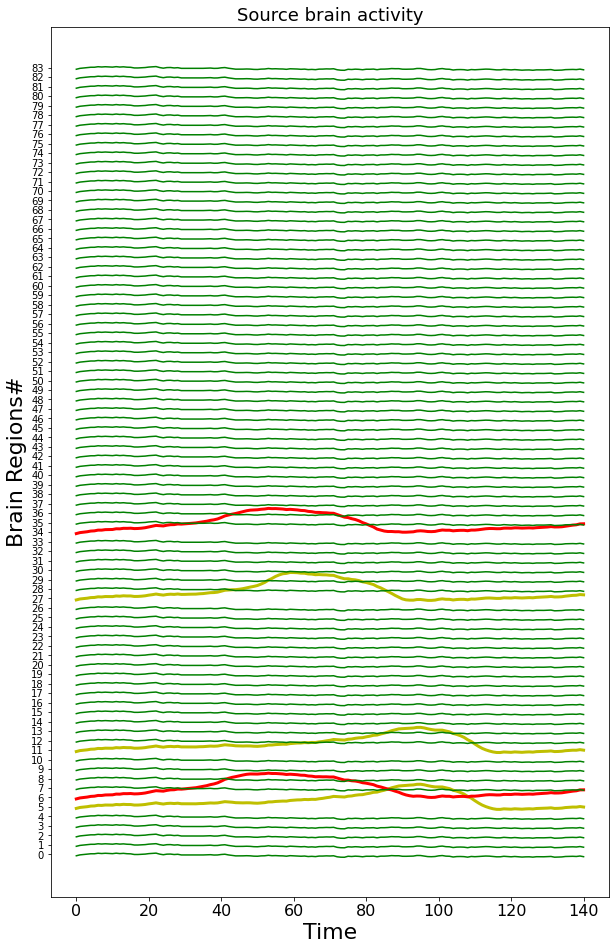

In [99]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

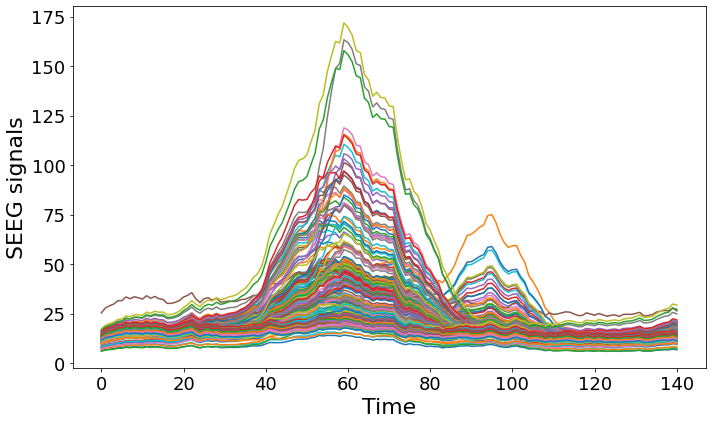

In [100]:
plt.figure(figsize=(10,6))
plt.plot(obs_seeg.T)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs_seeg_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

### Posterior

In [101]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [102]:
nodes=np.r_[0:nn]

In [103]:
num_samples=200

In [104]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 110 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


------------------------------------------------------------
--- sampling took: 48.92542576789856 seconds ---


In [105]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [106]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_GrExp_patient1_posteriorsamples.npy') , posterior_samples)

In [107]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [108]:
K_posterior.mean(), K_posterior.std()

(1.2343093, 0.40724245)

In [109]:
eta_c=-1.95
delta_eta=1.0              

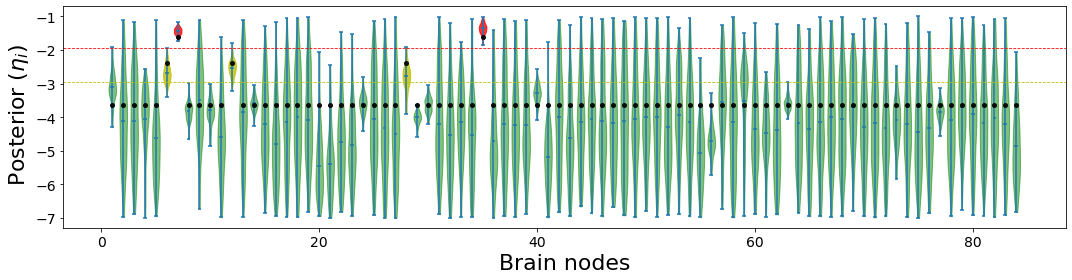

In [110]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

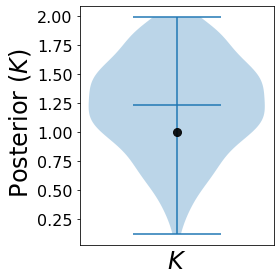

In [111]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);  
plt.xlabel(r'${K}$', fontsize=24); 
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [112]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)    

In [113]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

yfit_seeg= np.dot(Gr, np.exp(yfit_source))

In [114]:
y_fit=yfit_seeg
y_fit.shape

(162, 141)

In [115]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_GrExp_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_GrExp_patient1_y_fit.npy') , y_fit)

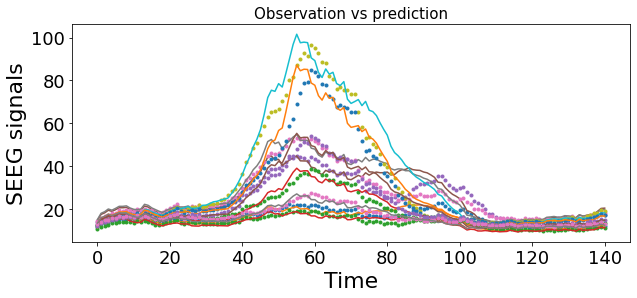

In [116]:
Rois=np.array([1, 6, 34, 50, 90, 100, 120, 130, 150])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

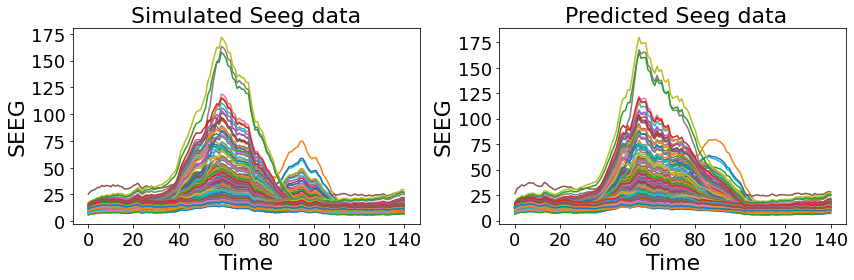

In [117]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_sde_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_sde_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

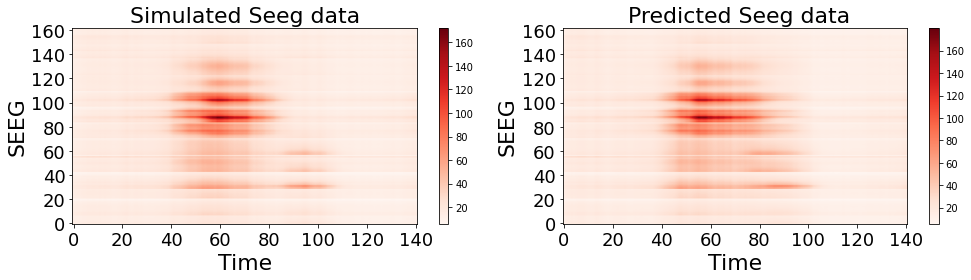

In [118]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0) 
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_sde_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_sde_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [119]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [120]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [121]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  3  0]
 [ 0  0 79]]


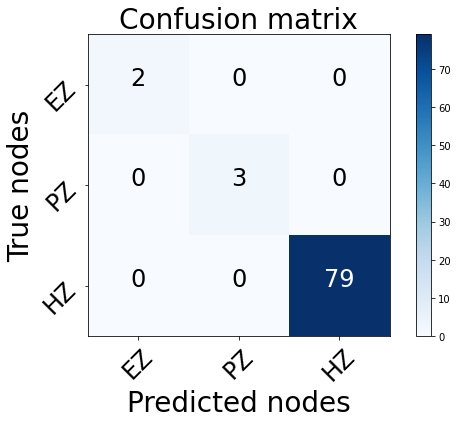

In [122]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [123]:
np.sum(np.std(eta_posterior, axis=0))

91.392624

In [124]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [125]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [126]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [127]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

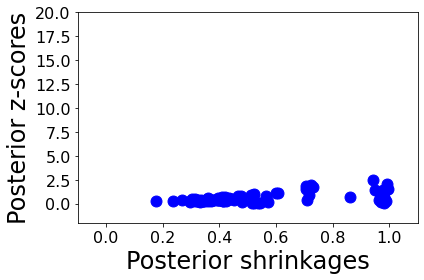

In [128]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [129]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(46.26825723648072, 0.6642343691463047)

In [130]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(55968.27382192334, 4.38560876047198)

In [131]:
dist_best.shape, np.std(eta_posterior, axis=0).shape

((84,), (84,))

In [132]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

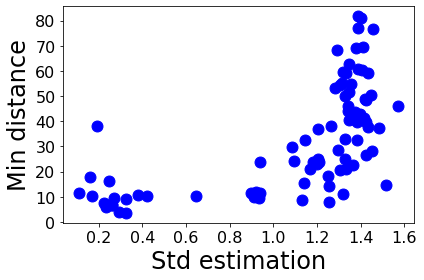

In [133]:
plt.scatter(np.std(eta_posterior, axis=0), dist_best, s=120, c='blue')
plt.ylabel('Min distance',fontsize=24)
plt.xlabel('Std estimation',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_PosteriorStd_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_PosteriorStd_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

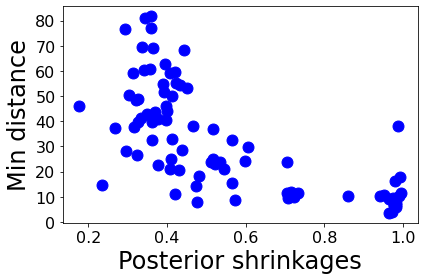

In [134]:
plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), dist_best, s=120, c='blue')
plt.ylabel('Min distance',fontsize=24)
plt.xlabel('Posterior shrinkages',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_Shrinkages_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_Shrinkages_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [135]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [136]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [137]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [138]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [139]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [140]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])    


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

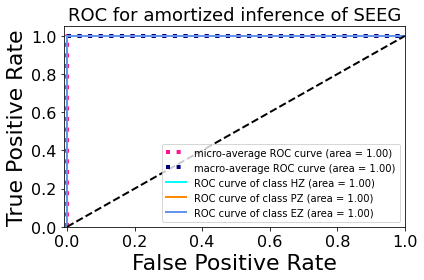

In [141]:
# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [142]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [143]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [144]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)

### Another Data set

In [145]:
hz_val=-3.65
pz_val=-2.5
ez_val=-1.7


ez_idx = np.array([7, 29],  dtype=np.int32)
pz_wplng_idx = np.array([6, 9, 28], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [146]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [147]:
K_true=1.

In [148]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [149]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [150]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

obs_seeg= np.dot(Gr, np.exp(obs_source))

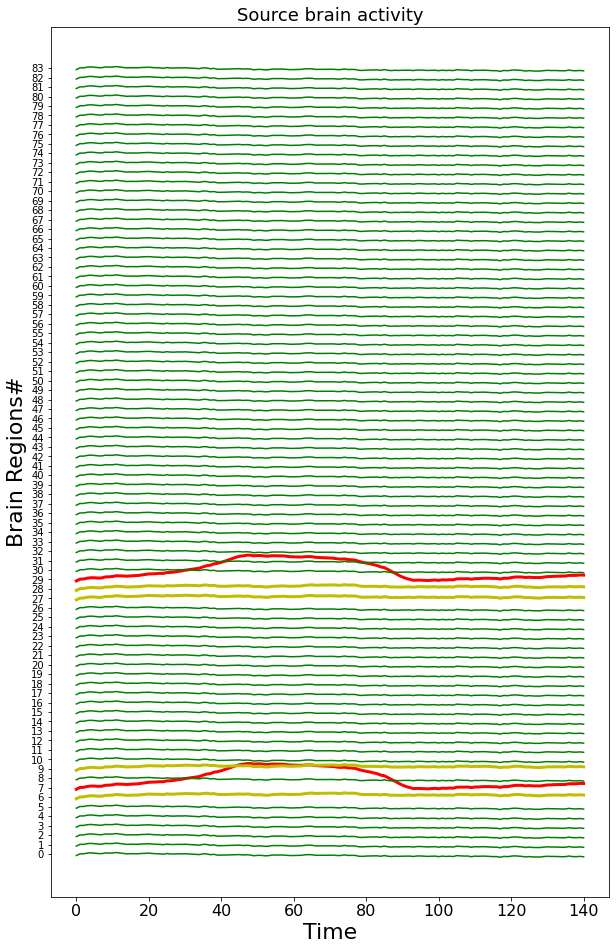

In [151]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [152]:
obs_summary_statistics=calculate_summary_statistics(obs_seeg.reshape(-1), nn, ns, nt)

In [153]:
obs_seeg.shape, obs_summary_statistics.shape

((162, 141), (8100,))

In [154]:
y_obs=obs_seeg
y_obs.shape

(162, 141)

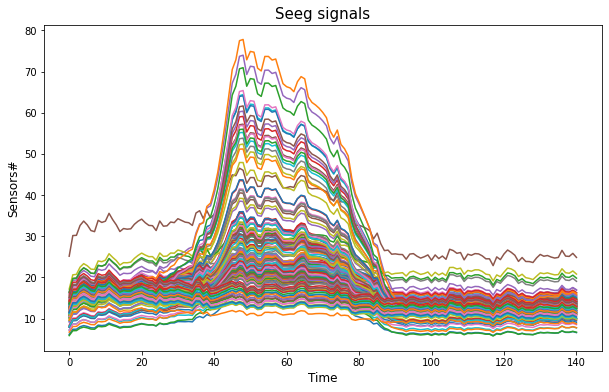

In [155]:
plt.figure(figsize=(10,6))
plt.plot(obs_seeg.T)
plt.title("Seeg signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Sensors#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [156]:
nodes=np.r_[0:nn]

In [157]:
num_samples=200

In [158]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 39.84884285926819 seconds ---


In [159]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [160]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_obs2_GrExp_patient1_posteriorsamples.npy') , posterior_samples)

In [161]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [162]:
K_posterior.mean(), K_posterior.std()

(1.30068, 0.4005166)

In [163]:
eta_c=-1.95
delta_eta=1.0              

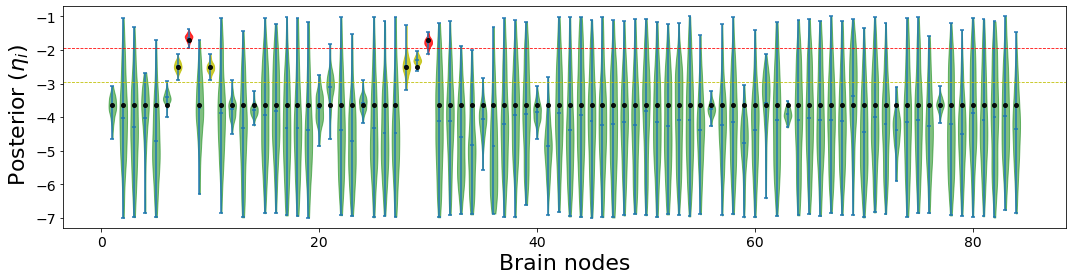

In [164]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

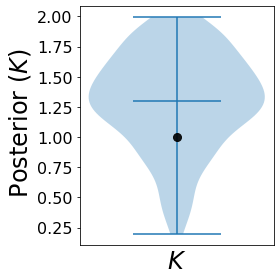

In [165]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);  
plt.xlabel(r'${K}$', fontsize=24); 
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [166]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)    

In [167]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

yfit_seeg= np.dot(Gr, np.exp(yfit_source))

In [168]:
y_fit=yfit_seeg
y_fit.shape

(162, 141)

In [169]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_obs2_GrExp_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_obs2_GrExp_patient1_y_fit.npy') , y_fit)

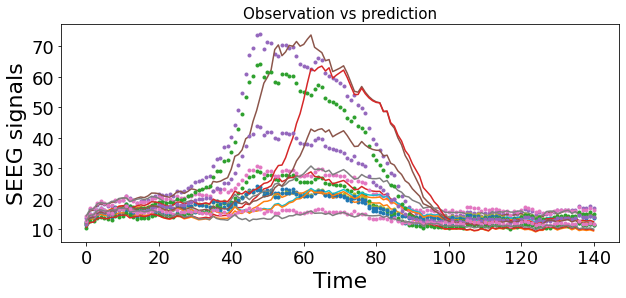

In [170]:
Rois=np.array([1, 6, 34, 50, 90, 100, 120, 130, 150])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

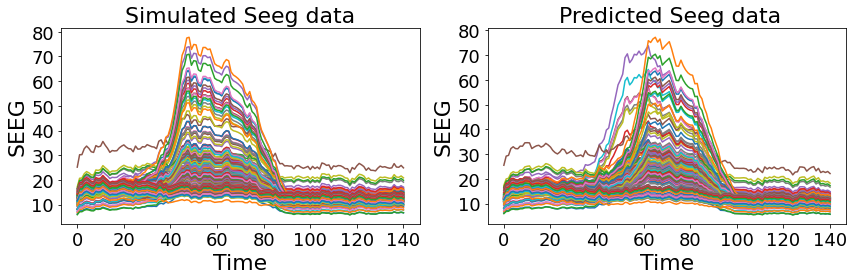

In [171]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_sde_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_sde_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

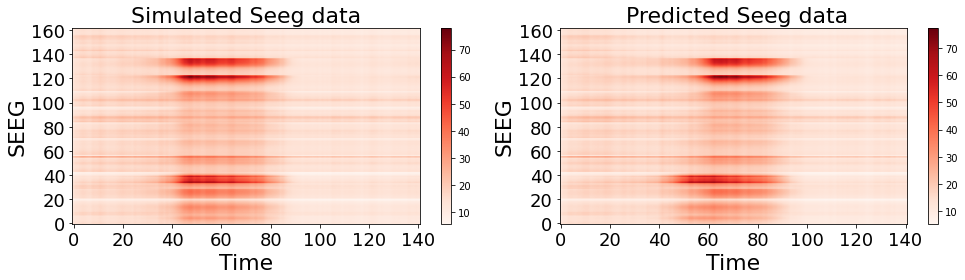

In [172]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0) 
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_sde_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_sde_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [173]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [174]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [175]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  4  0]
 [ 0  0 78]]


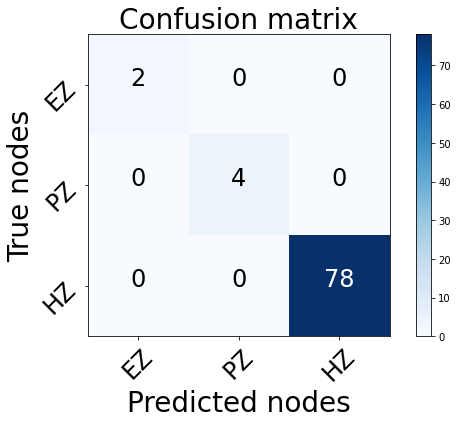

In [176]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [177]:
np.sum(np.std(eta_posterior, axis=0))

89.71712

In [178]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [179]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [180]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [181]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

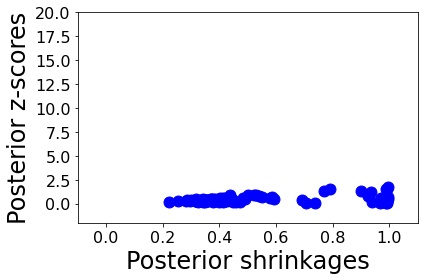

In [182]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs2_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [183]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(39.389103150367745, 0.554927057368174)

In [184]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(54603.59371848876, 4.503929378275102)

In [185]:
dist_best.shape, np.std(eta_posterior, axis=0).shape

((84,), (84,))

In [186]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

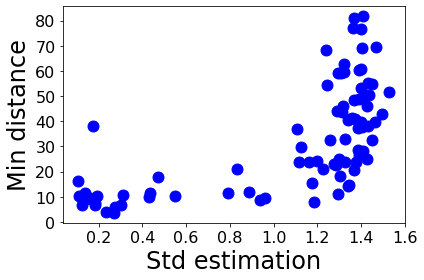

In [187]:
plt.scatter(np.std(eta_posterior, axis=0), dist_best, s=120, c='blue')
plt.ylabel('Min distance',fontsize=24)
plt.xlabel('Std estimation',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_PosteriorStd_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_PosteriorStd_obs2_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

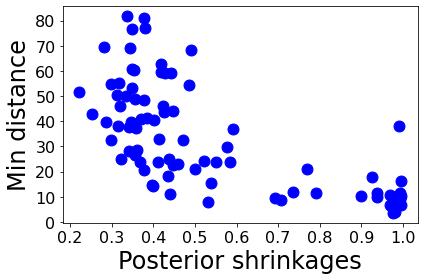

In [188]:
plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), dist_best, s=120, c='blue')
plt.ylabel('Min distance',fontsize=24)
plt.xlabel('Posterior shrinkages',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_Shrinkages_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_Shrinkages_obs2_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [189]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [190]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [191]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [192]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [193]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [194]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])    


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

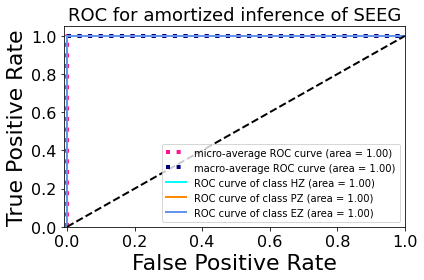

In [195]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [196]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [197]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [198]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)

### Another Data set

In [199]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34, 18, 45, 67, 81],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [200]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [201]:
K_true=1.

In [202]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [203]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [204]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

obs_seeg= np.dot(Gr, np.exp(obs_source))

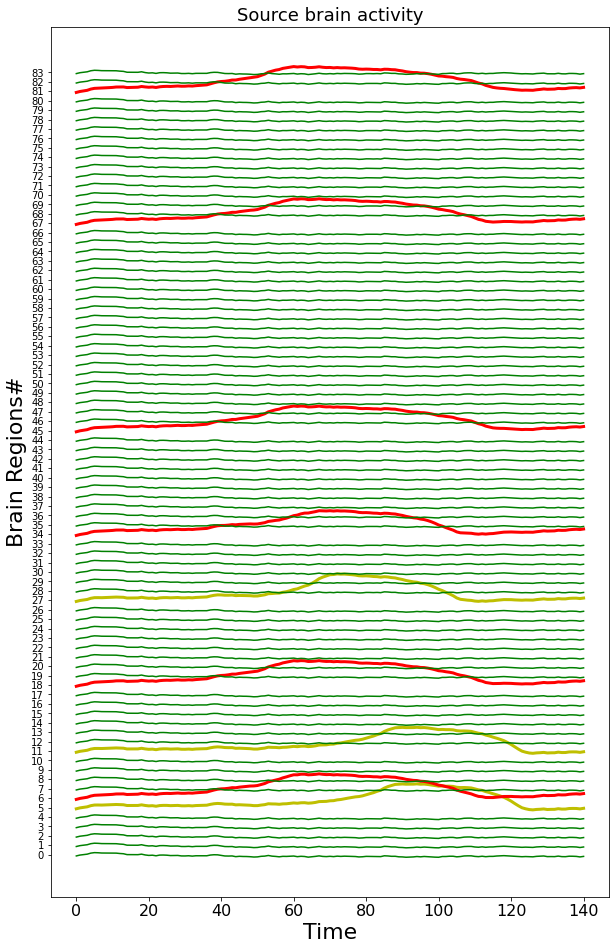

In [205]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [206]:
obs_summary_statistics=calculate_summary_statistics(obs_seeg.reshape(-1), nn, ns, nt)

In [207]:
obs_seeg.shape, obs_summary_statistics.shape

((162, 141), (8100,))

In [208]:
y_obs=obs_seeg
y_obs.shape

(162, 141)

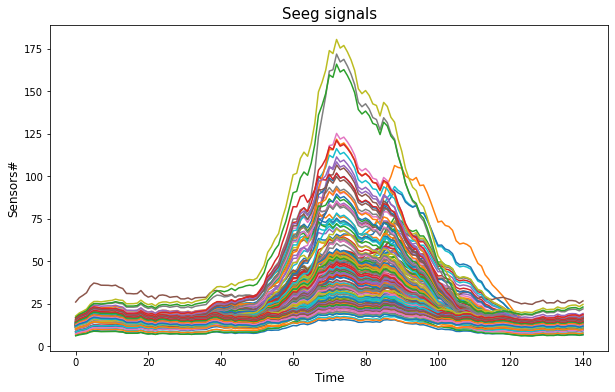

In [209]:
plt.figure(figsize=(10,6))
plt.plot(obs_seeg.T)
plt.title("Seeg signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Sensors#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [210]:
nodes=np.r_[0:nn]

In [211]:
num_samples=200

In [212]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 120 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


------------------------------------------------------------
--- sampling took: 51.627304553985596 seconds ---


In [213]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [214]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_obs3_GrExp_patient1_posteriorsamples.npy') , posterior_samples)

In [215]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [216]:
K_posterior.mean(), K_posterior.std()

(1.2463176, 0.38661763)

In [217]:
eta_c=-1.95
delta_eta=1.0              

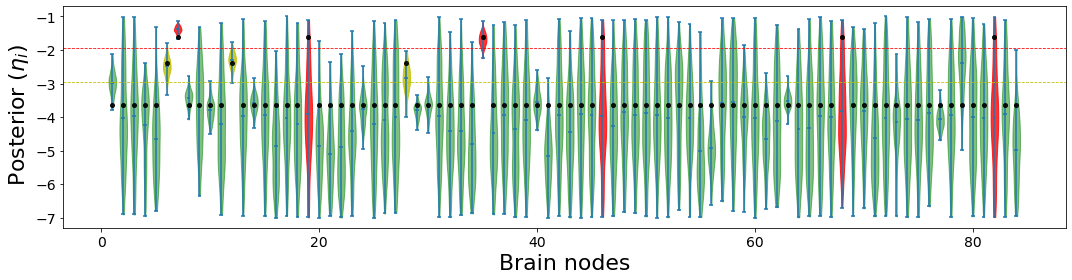

In [218]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

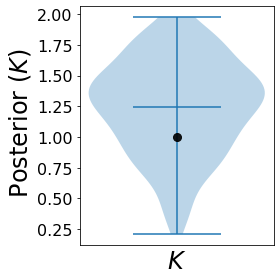

In [219]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);  
plt.xlabel(r'${K}$', fontsize=24); 
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [220]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)    

In [221]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

yfit_seeg= np.dot(Gr, np.exp(yfit_source))

In [222]:
y_fit=yfit_seeg
y_fit.shape

(162, 141)

In [223]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_obs3_GrExp_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_sde_sbi_seeg_obs3_GrExp_patient1_y_fit.npy') , y_fit)

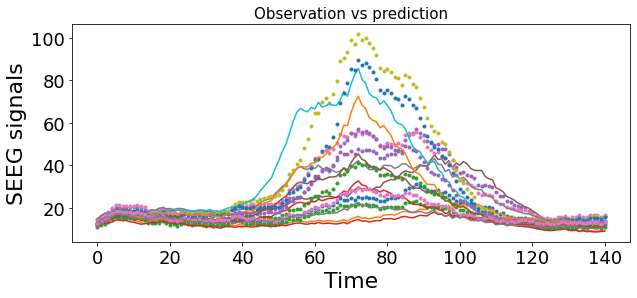

In [224]:
Rois=np.array([1, 6, 34, 50, 90, 100, 120, 130, 150])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

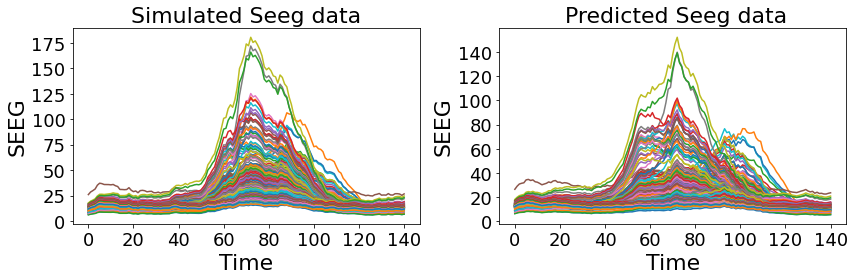

In [225]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_sde_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_sde_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

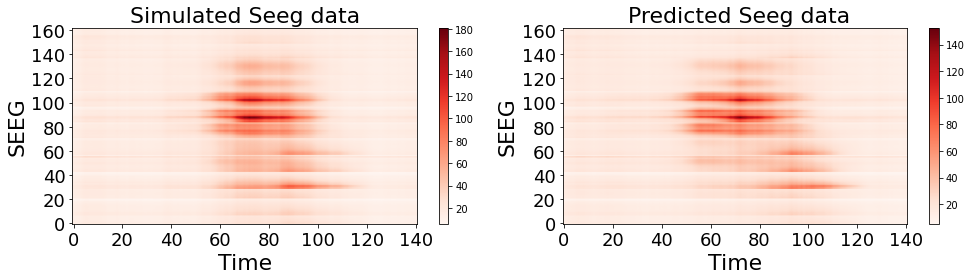

In [226]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Seeg data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0) 
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_sde_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_sde_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [227]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [228]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [229]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  4]
 [ 0  3  0]
 [ 0  1 74]]


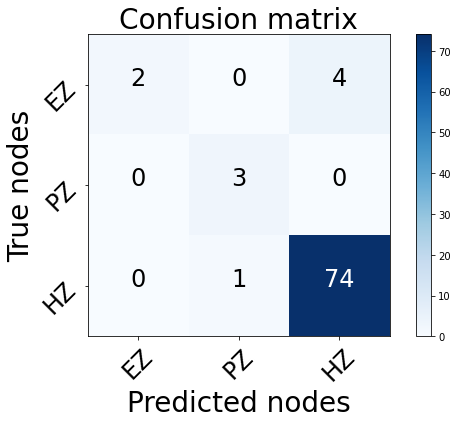

In [230]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [231]:
np.sum(np.std(eta_posterior, axis=0))

92.144485

In [232]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [233]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [234]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [235]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

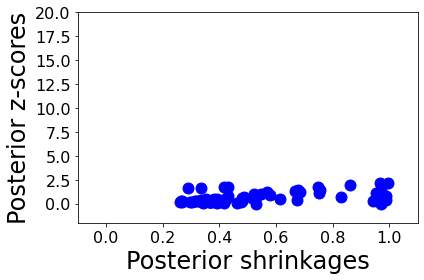

In [236]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_sde_obs3_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [237]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(48.75779039859772, 0.793765704523512)

In [238]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(95683.20357360094, 7.274969003447646)

In [239]:
dist_best.shape, np.std(eta_posterior, axis=0).shape

((84,), (84,))

In [240]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

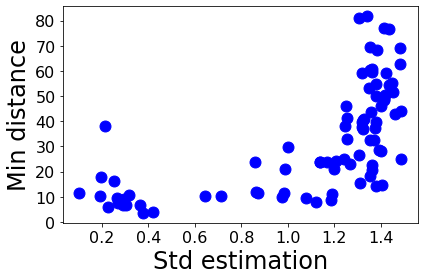

In [241]:
plt.scatter(np.std(eta_posterior, axis=0), dist_best, s=120, c='blue')
plt.ylabel('Min distance',fontsize=24)
plt.xlabel('Std estimation',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_PosteriorStd_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_PosteriorStd_obs3_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

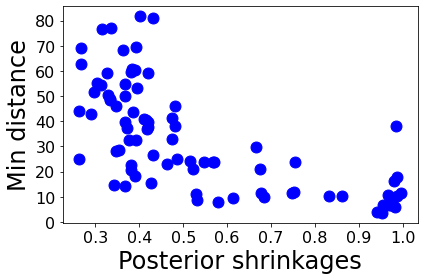

In [242]:
plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), dist_best, s=120, c='blue')
plt.ylabel('Min distance',fontsize=24)
plt.xlabel('Posterior shrinkages',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_Shrinkages_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Distances_Shrinkages_obs3_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [243]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [244]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [245]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [246]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [247]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [248]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])    


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

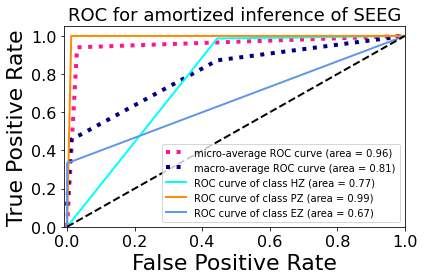

In [249]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [250]:
fpr

{0: array([0.        , 0.44444444, 1.        ]),
 1: array([0.        , 0.01234568, 1.        ]),
 2: array([0., 0., 1.]),
 'micro': array([0.       , 0.0297619, 1.       ]),
 'macro': array([0.        , 0.01234568, 0.44444444, 1.        ])}

In [251]:
tpr

{0: array([0.        , 0.98666667, 1.        ]),
 1: array([0., 1., 1.]),
 2: array([0.        , 0.33333333, 1.        ]),
 'micro': array([0.        , 0.94047619, 1.        ]),
 'macro': array([0.11111111, 0.45632373, 0.87209877, 1.        ])}

In [252]:
roc_auc["micro"], roc_auc["macro"]

(0.9553571428571429, 0.8105349794238683)